In [1]:
import pandas as pd
import numpy as np
import random
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from fancyimpute import KNN, NuclearNormMinimization

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from imblearn.under_sampling import *

from xgboost import XGBClassifier
from sklearn import svm
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.linear_model import ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

In [3]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [4]:
df_adult = pd.read_excel('2017-06-28_ABDoseAdult_MW-v4.xlsx')
df       = pd.read_excel('2017-06-28_ABDoseAdult_MW-v4.xlsx')

df_adult['fu48_clinical_outcome'] = df_adult['fu48_clinical_outcome'].replace(3,2)
df_adult['fu48_clinical_outcome'] = df_adult['fu48_clinical_outcome'].replace(4,3)

df_neat = pd.read_csv('Adult_copy_sample.csv')
df_neat = df_neat.iloc[:,2:]
df_neat = df_neat.iloc[:,:191]

# Classify success/failure

In [5]:
df_fu_48 = df_adult.iloc[:,163:849]
df_fu_48 = df_fu_48.drop(['fu48_los'], axis=1)

df_fu_48 = pd.concat([df_neat,
                      df_adult['apache'],
                      df_fu_48],axis=1)

drop_dict = ['hospadmin_egfr',
             'baseline_egfr',
             'sd1_warfarin_yn',
             'sd1_egfr_60',
             'sd1_egfr',
             'sd2_warfarin_yn',
             'sd2_egfr_60',
             'sd2_egfr',
             'other_no_of_doses']

for column in drop_dict:
    df_fu_48 = df_fu_48.drop([column], axis=1)

In [6]:
for column in df_fu_48:
    if  df_fu_48[column].isnull().sum()/len(df_fu_48) > 0.5:
        df_fu_48 = df_fu_48.drop([column], axis=1)
        
df_object = df_fu_48.select_dtypes(include=['object'])
df_fu_48 = df_fu_48.select_dtypes(exclude=['object'])

In [7]:
def onehot_column(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix = column_name)
    return dummies

cat_dict = ['sd1_vent',
            'sd1_gcs_eyes',
            'sd1_gcs_voice',
            'sd1_gcs_move',
            'sd1_abg_source',
            'sd2_vent',
            'sd2_gcs_eyes',
            'sd2_gcs_voice',
            'sd2_gcs_move',
            'sd2_abg_source']

for item in cat_dict:
    df_fu_48 = pd.concat([df_fu_48, onehot_column(df_fu_48, item)],axis=1)
    df_fu_48 = df_fu_48.drop([item],axis=1)

In [8]:
df_fu_48['fu48_clinical_outcome'] = df_fu_48['fu48_clinical_outcome'].replace(1,0)
df_fu_48['fu48_clinical_outcome'] = df_fu_48['fu48_clinical_outcome'].replace(2,1)
df_fu_48['fu48_clinical_outcome'] = df_fu_48['fu48_clinical_outcome'].replace(3,1)

In [44]:
df_nnm = NuclearNormMinimization().complete(df_fu_48)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 849140, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 415273, constraints m = 531337
Cones:	primal zero / dual free vars: 207363
	linear vars: 174096
	sd vars: 149878, sd blks: 1
Setup time: 5.63e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  3.50e-01 
   100| 6.59e-03  3.68e-03  5.97e-04  6.61e+04  6.62e+04  1.04e-11  2.72e+01 
   200| 2.18e-03  5.76e-04  3.11e-04  6.63e+04  6.63e+04  1.0

In [45]:
df_nnm = pd.DataFrame(df_nnm, columns=df_fu_48.columns, index=df_fu_48.index)

bmi = df_nnm['weight']/((df_nnm['height']/100)**2)
bmi = bmi.to_frame(name='bmi')
df_nnm = pd.concat([df_nnm,
                    bmi], axis=1)

np.any(np.isnan(df_nnm))

False

In [46]:
X = df_nnm.drop(['fu48_clinical_outcome'], axis=1)
Y = df_nnm['fu48_clinical_outcome']

# Normalisation
x = X.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled, columns=X.columns)

In [12]:
clf_xgb = XGBClassifier(learning_rate=0.1,
                        subsample=0.5,
                        n_estimators=5000,
                        min_child_weight=3,
                        gamma=0.0,
                        reg_alpha=0.01,
                        reg_lambda=1,
                        max_depth=3,
                        colsample_bytree=0.5)

In [86]:
y_pred = cross_val_predict(clf_xgb, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.43      0.38      0.40        55
        1.0       0.64      0.69      0.66        89

avg / total       0.56      0.57      0.56       144

0.533605720123
0.569444444444


In [13]:
clf_rf = RandomForestClassifier(bootstrap=False, 
                                min_samples_leaf=20, 
                                criterion='gini', 
                                min_samples_split=5, 
                                max_depth=3, 
                                n_estimators=100,
                                max_features='auto')

In [107]:
y_pred = cross_val_predict(clf_rf, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.80      0.07      0.13        55
        1.0       0.63      0.99      0.77        89

avg / total       0.70      0.64      0.53       144

0.530745658836
0.638888888889


In [18]:
clf_svm = svm.SVC(class_weight='balanced',
                  kernel='rbf',
                  C=1.6406707120152759,
                  gamma=0.092874643071059373,
                  probability=True)

In [120]:
y_pred = cross_val_predict(clf_svm, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.25      0.02      0.03        55
        1.0       0.61      0.97      0.75        89

avg / total       0.48      0.60      0.48       144

0.492236976507
0.604166666667


In [15]:
clf_lr = LogisticRegression(penalty='l2', 
                            dual=True, 
                            C=1000,
                            tol=0.0001,
                            fit_intercept=False,
                            intercept_scaling=1, 
                            random_state=None, 
                            solver='liblinear', 
                            max_iter=100, 
                            multi_class='ovr', 
                            verbose=0, 
                            warm_start=False, 
                            n_jobs=1)

In [240]:
y_pred = cross_val_predict(clf_lr, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.37      0.42      0.39        55
        1.0       0.61      0.56      0.58        89

avg / total       0.52      0.51      0.51       144

0.489989785495
0.506944444444


In [16]:
eclf1 = VotingClassifier(estimators=[('xgb', clf_xgb), 
                                     ('lr',  clf_lr),
                                     ('rf', clf_rf)],
                         voting='soft',
                         weights=[20,-2,1])

In [51]:
y_pred = cross_val_predict(eclf1, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.40      0.38      0.39        55
        1.0       0.63      0.65      0.64        89

avg / total       0.54      0.55      0.55       144

0.516751787538
0.548611111111


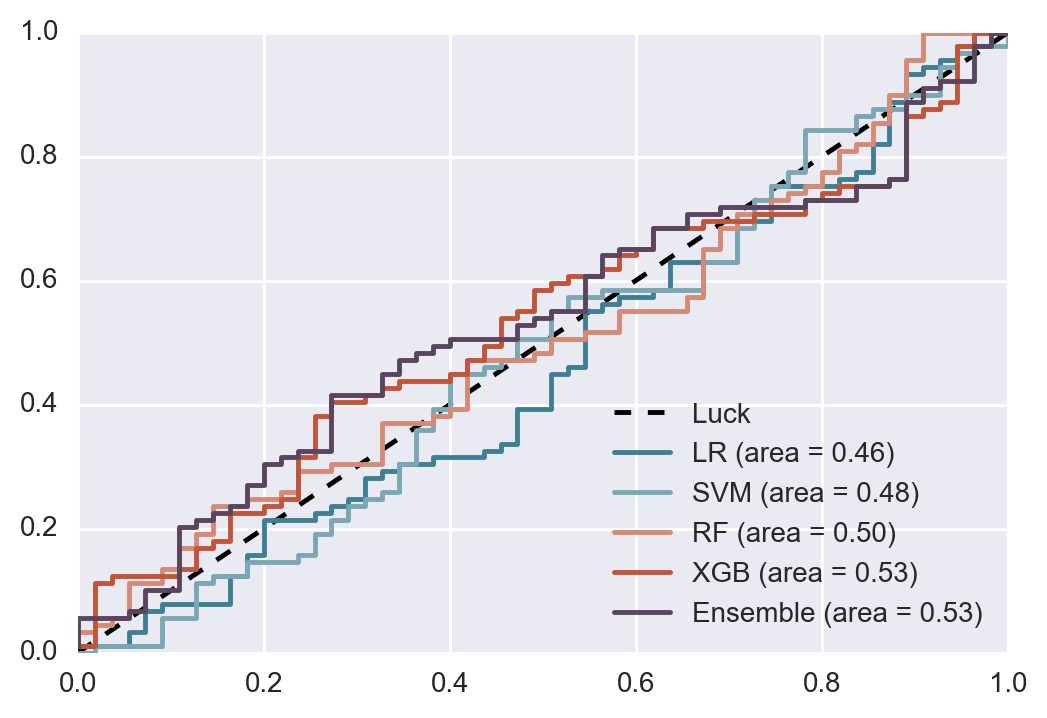

In [23]:
colors = ['#3f7f93', '#7ba7b5', '#d58a76', '#c25539', '#5a445e']

fpr_lr, tpr_lr, _ = roc_curve(Y, cross_val_predict(clf_lr, X, Y, cv=5, method='predict_proba')[:,1])
lr_auc = auc(fpr_lr, tpr_lr)
fpr_svm, tpr_svm, _ = roc_curve(Y, cross_val_predict(clf_svm, X, Y, cv=5, method='predict_proba')[:,1])
svm_auc = auc(fpr_svm, tpr_svm)
fpr_rf, tpr_rf, _ = roc_curve(Y, cross_val_predict(clf_rf, X, Y, cv=5, method='predict_proba')[:,1])
rf_auc = auc(fpr_rf, tpr_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(Y, cross_val_predict(clf_xgb, X, Y, cv=5, method='predict_proba')[:,1])
xgb_auc = auc(fpr_xgb, tpr_xgb)
fpr_en, tpr_en, _ = roc_curve(Y, cross_val_predict(eclf1, X, Y, cv=5, method='predict_proba')[:,1])
en_auc = auc(fpr_en, tpr_en)

plt.plot([0, 1], [0, 1], linestyle='--',color='k', label='Luck')
plt.plot(fpr_lr, tpr_lr, color=colors[0],   label='LR (area = %0.2f)' % (lr_auc))
plt.plot(fpr_svm, tpr_svm, color=colors[1], label='SVM (area = %0.2f)' % (svm_auc))
plt.plot(fpr_rf, tpr_rf, color=colors[2],   label='RF (area = %0.2f)' % (rf_auc))
plt.plot(fpr_xgb, tpr_xgb, color=colors[3], label='XGB (area = %0.2f)' % (xgb_auc))
plt.plot(fpr_en, tpr_en, color=colors[4],   label='Ensemble (area = %0.2f)' % (en_auc))

plt.legend(loc="lower right")
plt.savefig('sf_48.pdf')

# Elastic Net

In [47]:
model_EN = ElasticNetCV(copy_X=True,
                        cv=5, 
                        eps=0.001, 
                        fit_intercept=False,
                        l1_ratio=0.5, 
                        max_iter=1000, 
                        n_alphas=100, 
                        n_jobs=1,
                        normalize=False, 
                        positive=False, 
                        precompute='auto',
                        random_state=None, 
                        selection='cyclic', 
                        tol=0.0001, 
                        verbose=0)

model_EN.fit(X, Y)

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=False,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [48]:
coef_EN = pd.Series(model_EN.coef_, index = X.columns)
print("Elastic Net picked " + str(sum(coef_EN!=0)) + " variables and eliminated the other " +\
      str(sum(coef_EN==0)) + " variables")

Elastic Net picked 18 variables and eliminated the other 385 variables


In [49]:
cols = coef_EN[coef_EN!=0].index
X    = X[cols]

In [216]:
# SVM
NUM_TRIALS = 10

C_range = np.logspace(-5, 15, 11, base=2.0)
gamma_range = np.logspace(-15, 3, 10, base=2.0) # amendable

p_grid = dict(gamma=gamma_range, C=C_range)

svr = svm.SVC(kernel="rbf",
              class_weight='balanced',
              probability=True)

non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

for i in range(NUM_TRIALS):

    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svr, param_grid=p_grid, cv=inner_cv)
    clf.fit(X, Y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X, y=Y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()
    print('Iter', i+1,'/10 finished')

score_difference = non_nested_scores - nested_scores

print("Average difference of {0:6f} with std. dev. of {1:6f}."
      .format(score_difference.mean(), score_difference.std()))

print("The best parameters are %s with a score of %0.2f"
       % (clf.best_params_, clf.best_score_))

Iter 1 /10 finished
Iter 2 /10 finished
Iter 3 /10 finished
Iter 4 /10 finished
Iter 5 /10 finished
Iter 6 /10 finished
Iter 7 /10 finished
Iter 8 /10 finished
Iter 9 /10 finished
Iter 10 /10 finished
Average difference of 0.037108 with std. dev. of 0.031162.
The best parameters are {'gamma': 0.0078125, 'C': 512.0} with a score of 0.79


In [219]:
# Random Forest
p_grid = {"max_depth": [2, 3, 5],
          "min_samples_split": [2, 5],
          "min_samples_leaf": [10, 20, 50, 100],
          "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier(class_weight='balanced',
                            bootstrap=False,
                            n_estimators=300,
                            max_features='auto')

inner_cv = KFold(n_splits=5, shuffle=True)
clf = GridSearchCV(estimator=rf, param_grid=p_grid, cv=inner_cv)
clf.fit(X, Y)

print("The best parameters are %s with a score of %0.2f"
       % (clf.best_params_, clf.best_score_))

The best parameters are {'min_samples_split': 2, 'min_samples_leaf': 10, 'max_depth': 2, 'criterion': 'gini'} with a score of 0.75


In [258]:
# XGBoost
p_grid = {"learning_rate": [0.01, 0.05, 0.1, 0.2],
          "max_depth": [3],
          "min_child_weight": [1, 2, 3, 5],
          "gamma": [0.0, 0.01, 0.1, 1],
          "subsample": [0.5, 0.7, 1.0],
          "colsample_bytree": [0.5, 0.7, 1]}

clf_xgb = XGBClassifier(n_estimators=100,
                        scale_pos_weight=1.62)

inner_cv = KFold(n_splits=5, shuffle=True)
clf = GridSearchCV(estimator=clf_xgb, param_grid=p_grid, cv=inner_cv)
clf.fit(X, Y)

print("The best parameters are %s with a score of %0.2f"
       % (clf.best_params_, clf.best_score_))

The best parameters are {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.5, 'min_child_weight': 1} with a score of 0.80


In [33]:
clf_svm = svm.SVC(class_weight='balanced',
                  kernel='rbf',
                  C=512.0,
                  gamma=0.0078125,
                  probability=True)

In [218]:
y_pred = cross_val_predict(clf_svm, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.83      0.79      0.81        89
        1.0       0.57      0.64      0.60        39

avg / total       0.75      0.74      0.75       128

0.713771247479
0.659722222222


In [34]:
clf_rf = RandomForestClassifier(bootstrap=False, 
                                min_samples_leaf=3, 
                                criterion='gini', 
                                min_samples_split=2, 
                                max_depth=3, 
                                n_estimators=300,
                                max_features='auto')

In [241]:
y_pred = cross_val_predict(clf_rf, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.81      0.94      0.87        89
        1.0       0.79      0.49      0.60        39

avg / total       0.80      0.80      0.79       128

0.715499855949
0.715277777778


In [35]:
clf_lr = LogisticRegression(penalty='l2', 
                            dual=True, 
                            C=1,
                            tol=0.0001,
                            fit_intercept=False,
                            intercept_scaling=1, 
                            random_state=None, 
                            solver='liblinear', 
                            max_iter=100, 
                            multi_class='ovr', 
                            verbose=0, 
                            warm_start=False, 
                            n_jobs=1)

In [257]:
y_pred = cross_val_predict(clf_lr, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.79      0.81      0.80        89
        1.0       0.54      0.51      0.53        39

avg / total       0.71      0.72      0.72       128

0.660904638433
0.638888888889


In [36]:
clf_xgb = XGBClassifier(learning_rate=0.01,
                           subsample=0.5,
                           n_estimators=100,
                           min_child_weight=2,
                           scale_pos_weight=1.62,
                           reg_alpha=0,
                           reg_lambda=1,
                           max_depth=3,
                           colsample_bytree=0.5)

In [290]:
y_pred = cross_val_predict(clf_xgb, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.83      0.88      0.85        89
        1.0       0.68      0.59      0.63        39

avg / total       0.78      0.79      0.78       128

0.733074042063
0.701388888889


In [37]:
eclf1 = VotingClassifier(estimators=[('xgb', clf_xgb), 
                                     ('lr',  clf_lr),
                                     ('rf', clf_rf),
                                     ('svm', clf_svm)],
                         voting='soft',
                         weights=[7,1,1,1])

In [318]:
y_pred = cross_val_predict(eclf1, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.83      0.93      0.88        89
        1.0       0.79      0.56      0.66        39

avg / total       0.82      0.82      0.81       128

0.748343416883
0.729166666667


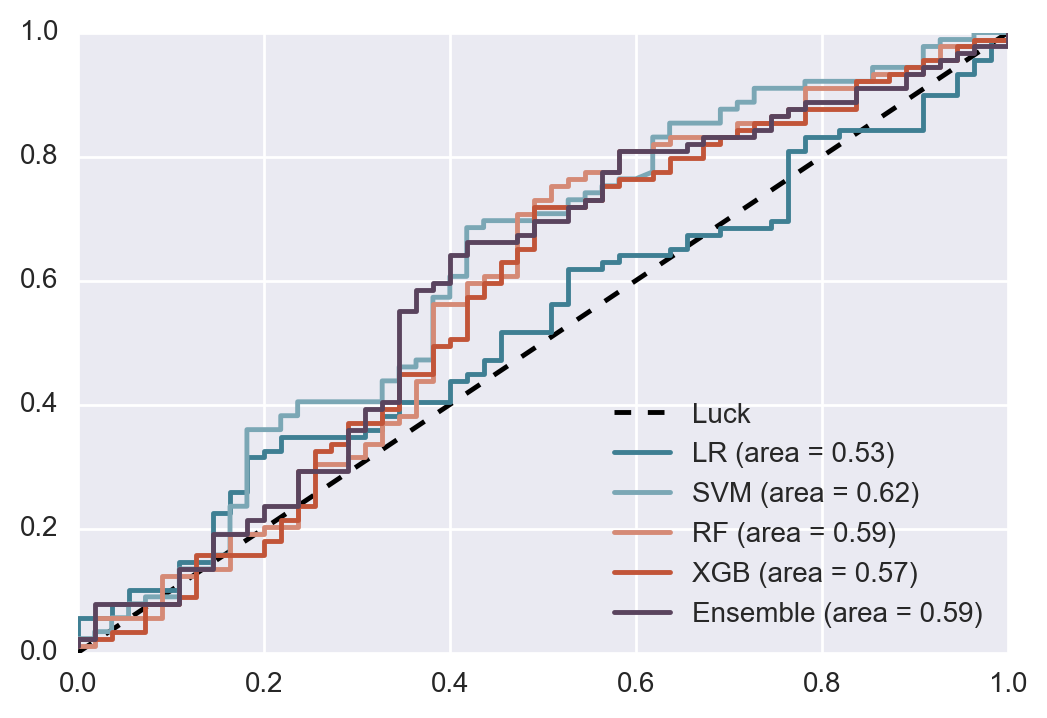

In [50]:
colors = ['#3f7f93', '#7ba7b5', '#d58a76', '#c25539', '#5a445e']

fpr_lr, tpr_lr, _ = roc_curve(Y, cross_val_predict(clf_lr, X, Y, cv=5, method='predict_proba')[:,1])
lr_auc = auc(fpr_lr, tpr_lr)
fpr_svm, tpr_svm, _ = roc_curve(Y, cross_val_predict(clf_svm, X, Y, cv=5, method='predict_proba')[:,1])
svm_auc = auc(fpr_svm, tpr_svm)
fpr_rf, tpr_rf, _ = roc_curve(Y, cross_val_predict(clf_rf, X, Y, cv=5, method='predict_proba')[:,1])
rf_auc = auc(fpr_rf, tpr_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(Y, cross_val_predict(clf_xgb, X, Y, cv=5, method='predict_proba')[:,1])
xgb_auc = auc(fpr_xgb, tpr_xgb)
fpr_en, tpr_en, _ = roc_curve(Y, cross_val_predict(eclf1, X, Y, cv=5, method='predict_proba')[:,1])
en_auc = auc(fpr_en, tpr_en)

plt.plot([0, 1], [0, 1], linestyle='--',color='k', label='Luck')
plt.plot(fpr_lr, tpr_lr, color=colors[0],   label='LR (area = %0.2f)' % (lr_auc))
plt.plot(fpr_svm, tpr_svm, color=colors[1], label='SVM (area = %0.2f)' % (svm_auc))
plt.plot(fpr_rf, tpr_rf, color=colors[2],   label='RF (area = %0.2f)' % (rf_auc))
plt.plot(fpr_xgb, tpr_xgb, color=colors[3], label='XGB (area = %0.2f)' % (xgb_auc))
plt.plot(fpr_en, tpr_en, color=colors[4],   label='Ensemble (area = %0.2f)' % (en_auc))

plt.legend(loc="lower right")
plt.savefig('sf_48_fs.pdf')

# 7 day follow up

In [51]:
df_fu_7 = df.iloc[:,849:991]
df_fu_7 = df_fu_7.drop(['fu7_los'], axis=1)

df_fu_7 = pd.concat([df_fu_48,
                     df_fu_7],axis=1)

drop_dict = ['fu48_cause_of_death',
             'fu48_cause_of_death_other',
             'fu48_abx_change_other',
             'abx_fu48_dose',
             'abx_fu48_freq',
             'abx_fu48_duration',
             'abx2_fu48_yn',
             'abx2_fu48_dose',
             'abx2_fu48_freq',
             'abx2_fu48_duration',
             'abx3_fu48_yn',
             'abx3_fu48_dose',
             'abx3_fu48_freq',
             'abx3_fu48_duration',
             'abx4_fu48_yn',
             'fu48_egfr']

for column in drop_dict:
    df_fu_7 = df_fu_7.drop([column], axis=1)

In [52]:
df_fu_7 = df_fu_7.select_dtypes(exclude=['object'])

for column in df_fu_7:
    if  df_fu_7[column].isnull().sum()/len(df_fu_7)>0.5:
        df_fu_7 = df_fu_7.drop([column], axis=1)

In [53]:
df_fu_7['fu7_clinical_outcome'] = df_fu_7['fu7_clinical_outcome'].replace(1,0)
df_fu_7['fu7_clinical_outcome'] = df_fu_7['fu7_clinical_outcome'].replace(2,1)
df_fu_7['fu7_clinical_outcome'] = df_fu_7['fu7_clinical_outcome'].replace(3,1)

df_fu_7 = df_fu_7.drop(['fu48_clinical_outcome'],axis=1)

In [54]:
df_fu_7 = pd.concat([df_fu_7,
                     df.fu48_clinical_outcome],axis=1)

df_fu_7 = df_fu_7.loc[df_fu_7['fu48_clinical_outcome'] != 4]

cat_dict = ['abx_fu48',
            'abx2_fu48',
            'abx3_fu48',
            'abx4_fu48',
            'fu48_vent',
            'fu48_gcs_eyes',
            'fu48_gcs_voice',
            'fu48_gcs_move',
            'fu48_abg_source',
            'hour_48_follow_up_complete']

for item in cat_dict:
    df_fu_7 = pd.concat([df_fu_7, onehot_column(df_fu_7, item)],axis=1)
    df_fu_7 = df_fu_7.drop([item],axis=1)

In [55]:
df_nnm = NuclearNormMinimization().complete(df_fu_7)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1008200, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 508857, constraints m = 634553
Cones:	primal zero / dual free vars: 254119
	linear vars: 188544
	sd vars: 191890, sd blks: 1
Setup time: 1.08e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  9.47e-01 
   100| 6.20e-03  3.68e-03  7.95e-04  6.63e+04  6.64e+04  9.74e-12  4.99e+01 
   200| 1.99e-03  7.30e-04  2.88e-04  6.64e+04  6.64e+04  3.

In [56]:
df_nnm = pd.DataFrame(df_nnm, columns=df_fu_7.columns, index=df_fu_7.index)

bmi = df_nnm['weight']/((df_nnm['height']/100)**2)
bmi = bmi.to_frame(name='bmi')
df_nnm = pd.concat([df_nnm,
                    bmi], axis=1)

np.any(np.isnan(df_nnm))

False

In [57]:
X = df_nnm.drop(['fu7_clinical_outcome'], axis=1)
Y = df_nnm['fu7_clinical_outcome']

x = X.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled, columns=X.columns)

In [59]:
# Logistic Regression
NUM_TRIALS = 20

p_grid = {"C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}

lr = LogisticRegression(penalty='l2', 
                        dual=False, 
                        tol=0.0001,
                        fit_intercept=True, 
                        intercept_scaling=1, 
                        random_state=None, 
                        solver='liblinear', 
                        max_iter=100, 
                        multi_class='ovr', 
                        verbose=0, 
                        warm_start=False, 
                        n_jobs=1)

non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=lr, param_grid=p_grid, cv=inner_cv)
    clf.fit(X, Y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(lr, X=X, y=Y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()
    print('Iter', i+1,'/20 finished')

score_difference = non_nested_scores - nested_scores

print("Average difference of {0:6f} with std. dev. of {1:6f}."
      .format(score_difference.mean(), score_difference.std()))

print("The best parameters are %s with a score of %0.2f"
       % (clf.best_params_, clf.best_score_))

Iter 1 /20 finished
Iter 2 /20 finished
Iter 3 /20 finished
Iter 4 /20 finished
Iter 5 /20 finished
Iter 6 /20 finished
Iter 7 /20 finished
Iter 8 /20 finished
Iter 9 /20 finished
Iter 10 /20 finished
Iter 11 /20 finished
Iter 12 /20 finished
Iter 13 /20 finished
Iter 14 /20 finished
Iter 15 /20 finished
Iter 16 /20 finished
Iter 17 /20 finished
Iter 18 /20 finished
Iter 19 /20 finished
Iter 20 /20 finished
Average difference of 0.040794 with std. dev. of 0.016515.
The best parameters are {'C': 0.0001} with a score of 0.70


In [88]:
# SVM
NUM_TRIALS = 10

C_range = np.logspace(-5, 15, 11, base=2.0)
gamma_range = np.logspace(-15, 3, 10, base=2.0) # amendable

p_grid = dict(gamma=gamma_range, C=C_range)

svr = svm.SVC(kernel="rbf",
              class_weight='balanced')
# svr = svm.SVC(kernel="linear")

non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svr, param_grid=p_grid, cv=inner_cv)
    clf.fit(X, Y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X, y=Y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()
    print('Iter', i+1,'/10 finished')

score_difference = non_nested_scores - nested_scores

print("Average difference of {0:6f} with std. dev. of {1:6f}."
      .format(score_difference.mean(), score_difference.std()))

print("The best parameters are %s with a score of %0.2f"
       % (clf.best_params_, clf.best_score_))

Iter 1 /10 finished
Iter 2 /10 finished
Iter 3 /10 finished
Iter 4 /10 finished
Iter 5 /10 finished
Iter 6 /10 finished
Iter 7 /10 finished
Iter 8 /10 finished
Iter 9 /10 finished
Iter 10 /10 finished
Average difference of 0.028828 with std. dev. of 0.020621.
The best parameters are {'gamma': 0.03125, 'C': 2.0} with a score of 0.73


In [136]:
# Random Forest
p_grid = {"max_depth": [2, 3, 5],
          "min_samples_split": [2, 5],
          "min_samples_leaf": [10, 20, 50, 100],
          "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier(class_weight='balanced',
                            bootstrap=False,
                            n_estimators=300,
                            max_features='auto')

inner_cv = KFold(n_splits=5, shuffle=True)
clf = GridSearchCV(estimator=rf, param_grid=p_grid, cv=inner_cv)
clf.fit(X, Y)

print("The best parameters are %s with a score of %0.2f"
       % (clf.best_params_, clf.best_score_))

The best parameters are {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 3, 'criterion': 'gini'} with a score of 0.75


In [171]:
# XGBoost
NUM_TRIALS = 20

p_grid = {"learning_rate": [0.01, 0.05, 0.1, 0.2],
          "max_depth": [3],
          "min_child_weight": [1, 2, 3, 5],
          "gamma": [0.0, 0.01, 0.1, 1],
          "subsample": [0.5, 0.7, 1.0],
          "colsample_bytree": [0.5, 0.7, 1]}

clf_xgb = XGBClassifier(scale_pos_weight=8, 
                        n_estimators=100)

inner_cv = KFold(n_splits=5, shuffle=True)
clf = GridSearchCV(estimator=clf_xgb, param_grid=p_grid, cv=inner_cv)
clf.fit(X, Y)

print("The best parameters are %s with a score of %0.2f"
       % (clf.best_params_, clf.best_score_))

The best parameters are {'colsample_bytree': 0.7, 'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.7, 'min_child_weight': 3} with a score of 0.78


In [58]:
clf_lr = LogisticRegression(penalty='l2', 
                            dual=True, 
                            C=1000000,
                            tol=0.0001,
                            fit_intercept=False,
                            intercept_scaling=1, 
                            random_state=None, 
                            solver='liblinear', 
                            max_iter=100, 
                            multi_class='ovr', 
                            verbose=0, 
                            warm_start=False, 
                            n_jobs=1)

In [87]:
y_pred = cross_val_predict(clf_lr, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.79      0.81      0.80        89
        1.0       0.54      0.51      0.53        39

avg / total       0.71      0.72      0.72       128

0.660904638433
0.71875


In [59]:
clf_svm = svm.SVC(class_weight='balanced',
                  kernel='rbf',
                  C=0.5,
                  gamma=0.03125,
                  probability=True)

In [134]:
y_pred = cross_val_predict(clf_svm, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.80      0.66      0.72        89
        1.0       0.44      0.62      0.52        39

avg / total       0.69      0.65      0.66       128

0.63915298185
0.6484375


In [60]:
clf_rf = RandomForestClassifier(bootstrap=False, 
                                min_samples_leaf=20, 
                                criterion='gini', 
                                min_samples_split=5, 
                                max_depth=2, 
                                n_estimators=300,
                                max_features='auto',
                                class_weight='balanced')

In [170]:
y_pred = cross_val_predict(clf_rf, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.81      0.82      0.82        89
        1.0       0.58      0.56      0.57        39

avg / total       0.74      0.74      0.74       128

0.692163641602
0.7421875


In [61]:
clf_xgb = XGBClassifier(learning_rate=0.01,
                        subsample=0.7,
                        n_estimators=5000,
                        min_child_weight=3,
                        gamma=0.01,
                        reg_alpha=0,
                        reg_lambda=1,
                        max_depth=3,
                        colsample_bytree=0.7)

In [185]:
y_pred = cross_val_predict(clf_xgb, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.75      0.90      0.82        89
        1.0       0.59      0.33      0.43        39

avg / total       0.70      0.73      0.70       128

0.616104868914
0.7265625


In [62]:
eclf2 = VotingClassifier(estimators=[('xgb', clf_xgb), 
                                     ('lr',  clf_lr),
                                     ('rf', clf_rf),
                                     ('svm', clf_svm)],
                         voting='soft',
                         weights=[5,1,5,1])

In [205]:
y_pred = cross_val_predict(eclf2, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.77      0.91      0.84        89
        1.0       0.65      0.38      0.48        39

avg / total       0.74      0.75      0.73       128

0.647363872083
0.75


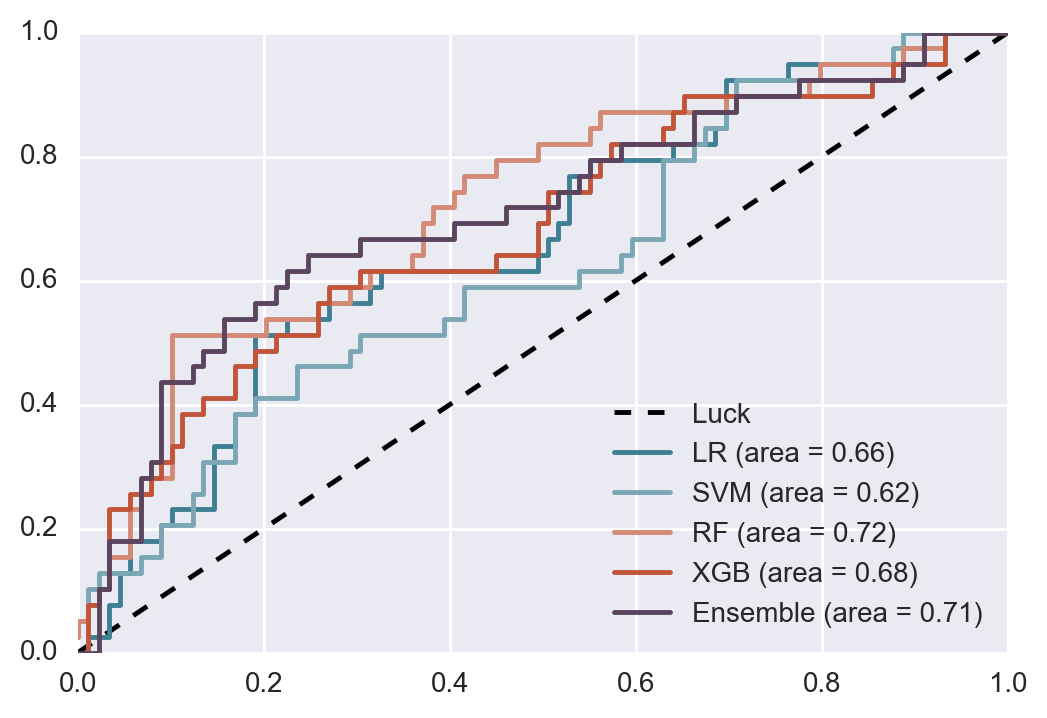

In [63]:
colors = ['#3f7f93', '#7ba7b5', '#d58a76', '#c25539', '#5a445e']

fpr_lr, tpr_lr, _ = roc_curve(Y, cross_val_predict(clf_lr, X, Y, cv=5, method='predict_proba')[:,1])
lr_auc = auc(fpr_lr, tpr_lr)
fpr_svm, tpr_svm, _ = roc_curve(Y, cross_val_predict(clf_svm, X, Y, cv=5, method='predict_proba')[:,1])
svm_auc = auc(fpr_svm, tpr_svm)
fpr_rf, tpr_rf, _ = roc_curve(Y, cross_val_predict(clf_rf, X, Y, cv=5, method='predict_proba')[:,1])
rf_auc = auc(fpr_rf, tpr_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(Y, cross_val_predict(clf_xgb, X, Y, cv=5, method='predict_proba')[:,1])
xgb_auc = auc(fpr_xgb, tpr_xgb)
fpr_en, tpr_en, _ = roc_curve(Y, cross_val_predict(eclf1, X, Y, cv=5, method='predict_proba')[:,1])
en_auc = auc(fpr_en, tpr_en)

plt.plot([0, 1], [0, 1], linestyle='--',color='k', label='Luck')
plt.plot(fpr_lr, tpr_lr, color=colors[0],   label='LR (area = %0.2f)' % (lr_auc))
plt.plot(fpr_svm, tpr_svm, color=colors[1], label='SVM (area = %0.2f)' % (svm_auc))
plt.plot(fpr_rf, tpr_rf, color=colors[2],   label='RF (area = %0.2f)' % (rf_auc))
plt.plot(fpr_xgb, tpr_xgb, color=colors[3], label='XGB (area = %0.2f)' % (xgb_auc))
plt.plot(fpr_en, tpr_en, color=colors[4],   label='Ensemble (area = %0.2f)' % (en_auc))

plt.legend(loc="lower right")
plt.savefig('sf_7.pdf')

# Elastic Net

In [64]:
model_EN = ElasticNetCV(copy_X=True,
                        cv=5, 
                        eps=0.001, 
                        fit_intercept=False,
                        l1_ratio=0.5, 
                        max_iter=1000, 
                        n_alphas=100, 
                        n_jobs=1,
                        normalize=False, 
                        positive=False, 
                        precompute='auto',
                        random_state=None, 
                        selection='cyclic', 
                        tol=0.0001, 
                        verbose=0)

model_EN.fit(X, Y)

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=False,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [65]:
coef_EN = pd.Series(model_EN.coef_, index = X.columns)
print("Elastic Net picked " + str(sum(coef_EN!=0)) + " variables and eliminated the other " +\
      str(sum(coef_EN==0)) + " variables")

Elastic Net picked 20 variables and eliminated the other 471 variables


In [66]:
cols = coef_EN[coef_EN!=0].index
X    = X[cols]

In [327]:
# SVM
NUM_TRIALS = 10

C_range = np.logspace(-5, 15, 11, base=2.0)
gamma_range = np.logspace(-15, 3, 10, base=2.0) # amendable

p_grid = dict(gamma=gamma_range, C=C_range)

svr = svm.SVC(kernel="rbf",
              class_weight='balanced')
# svr = svm.SVC(kernel="linear")

non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svr, param_grid=p_grid, cv=inner_cv)
    clf.fit(X, Y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X, y=Y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()
    print('Iter', i+1,'/10 finished')

score_difference = non_nested_scores - nested_scores

print("Average difference of {0:6f} with std. dev. of {1:6f}."
      .format(score_difference.mean(), score_difference.std()))

print("The best parameters are %s with a score of %0.2f"
       % (clf.best_params_, clf.best_score_))

Iter 1 /10 finished
Iter 2 /10 finished
Iter 3 /10 finished
Iter 4 /10 finished
Iter 5 /10 finished
Iter 6 /10 finished
Iter 7 /10 finished
Iter 8 /10 finished
Iter 9 /10 finished
Iter 10 /10 finished
Average difference of 0.037108 with std. dev. of 0.031162.
The best parameters are {'gamma': 0.0078125, 'C': 512.0} with a score of 0.79


In [338]:
# Random Forest
p_grid = {"max_depth": [2, 3, 5],
          "min_samples_split": [2, 5],
          "min_samples_leaf": [10, 20, 50, 100],
          "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier(class_weight='balanced',
                            bootstrap=False,
                            n_estimators=300,
                            max_features='auto')

inner_cv = KFold(n_splits=5, shuffle=True)
clf = GridSearchCV(estimator=rf, param_grid=p_grid, cv=inner_cv)
clf.fit(X, Y)

print("The best parameters are %s with a score of %0.2f"
       % (clf.best_params_, clf.best_score_))

The best parameters are {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 2, 'criterion': 'entropy'} with a score of 0.78


In [368]:
# XGBoost
NUM_TRIALS = 20

p_grid = {"learning_rate": [0.01, 0.05, 0.1, 0.2],
          "max_depth": [3],
          "min_child_weight": [1, 2, 3, 5],
          "gamma": [0.0, 0.01, 0.1, 1],
          "subsample": [0.5, 0.7, 1.0],
          "colsample_bytree": [0.5, 0.7, 1]}

clf_xgb = XGBClassifier(scale_pos_weight=8, 
                        n_estimators=100)

inner_cv = KFold(n_splits=5, shuffle=True)
clf = GridSearchCV(estimator=clf_xgb, param_grid=p_grid, cv=inner_cv)
clf.fit(X, Y)

print("The best parameters are %s with a score of %0.2f"
       % (clf.best_params_, clf.best_score_))

The best parameters are {'colsample_bytree': 1, 'gamma': 0.0, 'learning_rate': 0.2, 'max_depth': 3, 'subsample': 1.0, 'min_child_weight': 1} with a score of 0.79


In [67]:
clf_svm = svm.SVC(class_weight='balanced',
                  kernel='rbf',
                  C=64.0,
                  gamma=0.0078125,
                  probability=True)

In [337]:
y_pred = cross_val_predict(clf_svm, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.85      0.83      0.84        89
        1.0       0.63      0.67      0.65        39

avg / total       0.78      0.78      0.78       128

0.749063670412
0.78125


In [68]:
clf_rf = RandomForestClassifier(bootstrap=False, 
                                min_samples_leaf=20, 
                                criterion='entropy', 
                                min_samples_split=5, 
                                max_depth=2, 
                                n_estimators=300,
                                max_features='auto',
                                class_weight='balanced')

In [352]:
y_pred = cross_val_predict(clf_rf, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.88      0.76      0.82        89
        1.0       0.59      0.77      0.67        39

avg / total       0.79      0.77      0.77       128

0.766637856525
0.765625


In [69]:
clf_lr = LogisticRegression(penalty='l2', 
                            dual=True, 
                            C=10,
                            tol=0.0001,
                            fit_intercept=True,
                            intercept_scaling=1, 
                            random_state=None, 
                            solver='liblinear', 
                            max_iter=100, 
                            multi_class='ovr', 
                            verbose=0, 
                            warm_start=False, 
                            n_jobs=1)

In [367]:
y_pred = cross_val_predict(clf_lr, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.83      0.88      0.85        89
        1.0       0.68      0.59      0.63        39

avg / total       0.78      0.79      0.78       128

0.733074042063
0.7890625


In [70]:
clf_xgb = XGBClassifier(learning_rate=0.2,
                        subsample=1.0,
                        n_estimators=10,
                        min_child_weight=1,
                        gamma=0.0,
                        reg_alpha=0,
                        reg_lambda=1,
                        max_depth=3,
                        colsample_bytree=1)

In [410]:
y_pred = cross_val_predict(clf_xgb, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.83      0.89      0.86        89
        1.0       0.70      0.59      0.64        39

avg / total       0.79      0.80      0.79       128

0.738692019591
0.796875


In [71]:
eclf2 = VotingClassifier(estimators=[('rf', clf_rf), 
                                     ('lr',  clf_lr),
                                     ('svm', clf_svm),
                                     ('xgb', clf_xgb)],
                         voting='soft',
                         weights=[10,1,1,1])

In [426]:
y_pred = cross_val_predict(eclf1, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.86      0.83      0.85        89
        1.0       0.64      0.69      0.67        39

avg / total       0.79      0.79      0.79       128

0.761884183232
0.7890625


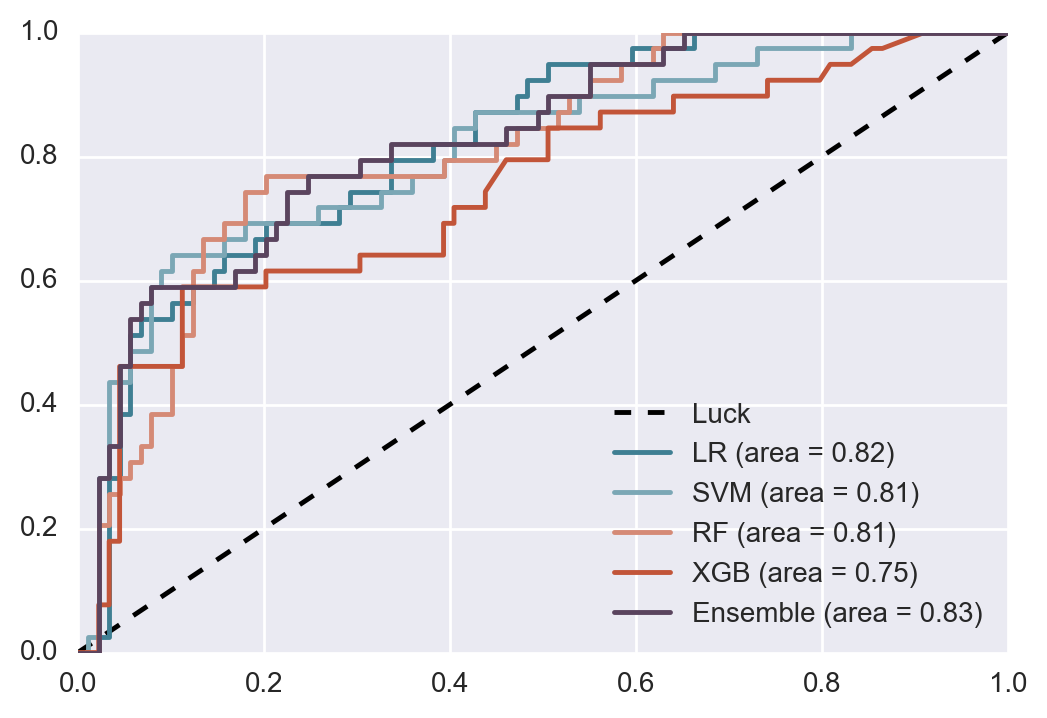

In [72]:
colors = ['#3f7f93', '#7ba7b5', '#d58a76', '#c25539', '#5a445e']

fpr_lr, tpr_lr, _ = roc_curve(Y, cross_val_predict(clf_lr, X, Y, cv=5, method='predict_proba')[:,1])
lr_auc = auc(fpr_lr, tpr_lr)
fpr_svm, tpr_svm, _ = roc_curve(Y, cross_val_predict(clf_svm, X, Y, cv=5, method='predict_proba')[:,1])
svm_auc = auc(fpr_svm, tpr_svm)
fpr_rf, tpr_rf, _ = roc_curve(Y, cross_val_predict(clf_rf, X, Y, cv=5, method='predict_proba')[:,1])
rf_auc = auc(fpr_rf, tpr_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(Y, cross_val_predict(clf_xgb, X, Y, cv=5, method='predict_proba')[:,1])
xgb_auc = auc(fpr_xgb, tpr_xgb)
fpr_en, tpr_en, _ = roc_curve(Y, cross_val_predict(eclf1, X, Y, cv=5, method='predict_proba')[:,1])
en_auc = auc(fpr_en, tpr_en)

plt.plot([0, 1], [0, 1], linestyle='--',color='k', label='Luck')
plt.plot(fpr_lr, tpr_lr, color=colors[0],   label='LR (area = %0.2f)' % (lr_auc))
plt.plot(fpr_svm, tpr_svm, color=colors[1], label='SVM (area = %0.2f)' % (svm_auc))
plt.plot(fpr_rf, tpr_rf, color=colors[2],   label='RF (area = %0.2f)' % (rf_auc))
plt.plot(fpr_xgb, tpr_xgb, color=colors[3], label='XGB (area = %0.2f)' % (xgb_auc))
plt.plot(fpr_en, tpr_en, color=colors[4],   label='Ensemble (area = %0.2f)' % (en_auc))

plt.legend(loc="lower right")
plt.savefig('sf_7_fs.pdf')

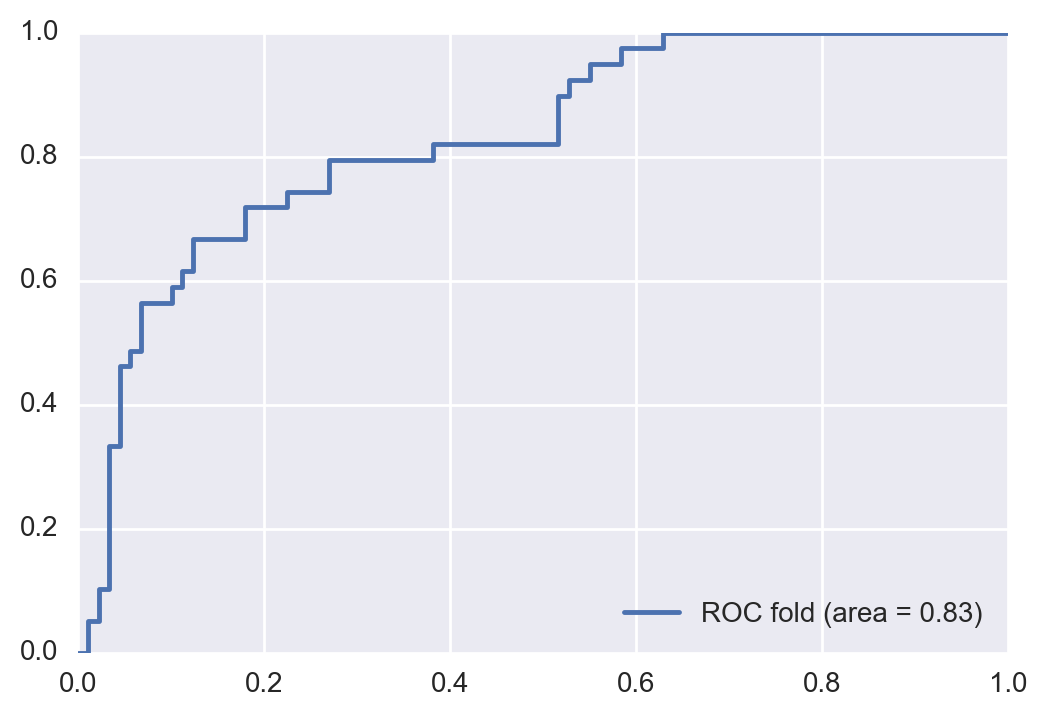

In [439]:
fpr_grd, tpr_grd, _ = roc_curve(Y, cross_val_predict(eclf1, X, Y, cv=5, method='predict_proba')[:,1])
eclf1_auc = auc(fpr_grd, tpr_grd)
plt.plot(fpr_grd, tpr_grd, label='ROC fold (area = %0.2f)' % (roc_auc))
plt.legend(loc="lower right")